In [1]:
note="k_zoomin2_cs"

In [2]:
# This one uses processed Ws inputs, so one does not have to input the array sizes manually
import qpms
from qpms.symmetries import  gen_hexlattice_Kpoint_svwf_rep, gen_hexlattice_Kpoint_svwf_rep_projectors
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import interpolate
from scipy.constants import e as eV, hbar, hbar as ℏ, c
ň = np.newaxis
import cmath

In [3]:
evfactor =  (eV/hbar) /( 3e8 / 1e-6 )
evfactor * 1.38, evfactor * 1.5

(6.988630318682703, 7.596337302915982)

In [4]:
Wfile = '/m/phys/project/qd/Marek/deep_thin_cs/lMax3zoom2'
#force_lMax = 2
#nelem = force_lMax * (force_lMax+2)

In [5]:
#wdata = wdata_long
wdata = qpms.loadWfile_processed(Wfile, lMax=3, midk_halfwidth=7, freqlimits=(1.440*eV/ℏ,1.442*eV/ℏ))
lMax = wdata['lMax']
nelem = wdata['nelem']

In [6]:
#wdata.keys(), wdata['nk'], wdata['ks'], wdata['Ws'].shape

In [7]:
#### T-matrices from file
# Original Ag:
TMatrix_file = '/u/46/necadam1/unix/tmatrix-experiments/Cylinder/hexlasingPaper/cylinder_50nm_lMax3_longer_cleaned.TMatrix'
# Zero loss "Ag":
#TMatrix_file = '/u/46/necadam1/unix/tmatrix-experiments/Cylinder/hexlasingPaper/zeroloss/cylinder_50nm_lMax2_long.TMatrix'

TMatrices_orig, freqs_orig, freqs_weirdunits_orig, lMaxTM = qpms.loadScuffTMatrices(TMatrix_file, normalisation = 2, version = 'new')
tmtype="Scuff"

In [8]:
# TODO synchronize the TM/W lMaxes better
TMatrices_orig = TMatrices_orig[...,:,0:nelem,:,0:nelem]
lMaxTM = lMax

In [9]:
freqs_orig[0] / (eV/hbar), freqs_orig[-1] / (eV/hbar)

(0.19732697880919506, 2.1705967669011454)

In [144]:
#### Alternatively, Mie T-matrix
#lMaxTM = force_lMax
lMax = lMaxTM

nelem = lMax * (lMax + 2)
startω =1*eV/ℏ
stopω = 2*eV/ℏ
ωlist = np.linspace(startω, stopω, 200)


ε_b = 2.13
R = 40e-9

if False: # drude model
    ω_p = 9*eV/ℏ #9*eV/ℏ
    ε_inf = 4.6
    γ_p = 0#0.07*eV/ℏ
    
    ε_mlist = qpms.ε_drude(ε_inf, ω_p, γ_p, ωlist)
    tmtype="MieDrude%gnm" % (R/1e-9)
else: # interpolated data
    permdata = np.loadtxt("/u/46/necadam1/unix/tmatrix-experiments/materialy/Au-Johnson-simple.dat")
    permfreqs = permdata[:,0]
    permvals = permdata[:,1] + permdata[:,2]*1j
    permdata_interp = interpolate.interp1d(permfreqs, permvals, axis = 0, kind='linear', fill_value='extrapolate')
    ε_mlist = permdata_interp(ωlist)
    tmtype="MieInterp%gnm" % (R/1e-9)
    

RVlist = np.empty((lMax+1,)+ωlist.shape,dtype=np.complex_)
RHlist = np.empty((lMax+1,)+ωlist.shape,dtype=np.complex_)

for i in range(len(ωlist)):
    ω=ωlist[i]
    k_i = cmath.sqrt(ε_mlist[i])*ω/c
    k_e = cmath.sqrt(ε_b)*ω/c
    RH, RV, TH, TV = qpms.mie_coefficients(a=R, nmax=lMax, k_i=k_i, k_e=k_e, J_ext=1, J_scat=3)
    RVlist[:,i] = RV
    RHlist[:,i] = RH

y = np.arange(nelem)
my, ny = qpms.get_mn_y(lMax)

TMatrices_orig = np.zeros((RVlist.shape[1], 2, nelem, 2, nelem), dtype=complex)

for l in range(1,lMax+1):
    beg = l**2-1
    end = l*(l+2)
    TMatrices_orig[:,0,beg:end,0,beg:end] = -RVlist[l,:,ň,ň] * np.eye(2*l+1) # FIXME opposite sign?
    TMatrices_orig[:,1,beg:end,1,beg:end] = -RHlist[l,:,ň,ň] * np.eye(2*l+1)

freqs_orig = ωlist

In [10]:
lMax = lMaxTM  # redundant
nelem = qpms.get_nelem(lMax) #redundant
nomega = wdata['nfreqs'] # 286
nk = wdata['nk'] #100
npart = wdata['npart']
wdata['freqs'][0]/(eV/hbar), wdata['freqs'][-1] / (eV/hbar)

(1.4400034942090416, 1.4419964966950145)

In [11]:
#symmetrize TMatrices
yfl = qpms.yflip_tyty(lMax)
xfl = qpms.xflip_tyty(lMax)
zfl = qpms.zflip_tyty(lMax)
TMatrix=TMatrices_orig
TMatrix_sym = (TMatrix + qpms.apply_ndmatrix_left(yfl,qpms.apply_ndmatrix_left(yfl, TMatrix, (-4,-3)),(-2,-1)))/2
TMatrix_sym = (TMatrix_sym + qpms.apply_ndmatrix_left(xfl,qpms.apply_ndmatrix_left(xfl, TMatrix_sym, (-4,-3)),(-2,-1)))/2
TMatrix_sym = (TMatrix_sym + qpms.apply_ndmatrix_left(zfl,qpms.apply_ndmatrix_left(zfl, TMatrix_sym, (-4,-3)),(-2,-1)))/2
rotN = 600

TMatrix_contribs = np.empty((rotN,)+TMatrix.shape, dtype=np.complex_)
for i in range(rotN):
    rotangle = 2*np.pi*i / rotN
    rot =  qpms.WignerD_yy_fromvector(lMax,np.array([0,0,rotangle]))
    rotinv = qpms.WignerD_yy_fromvector(lMax,np.array([0,0,-rotangle]))
    TMatrix_contribs[i] = qpms.apply_matrix_left(rot,qpms.apply_matrix_left(rotinv, TMatrix_sym, -3),-1)
TMatrix_sym = np.sum(TMatrix_contribs, axis=0) / rotN
TMatrix_sym[np.abs(TMatrix_sym) <= 1e-16] = 0

In [12]:
# TODO process (interpolate and symmetrize) T-matrix here
TMatrices_interp = interpolate.interp1d(freqs_orig, TMatrix_sym, axis = 0, kind='linear', fill_value='extrapolate')


In [13]:
Wmatrices = wdata['Ws']#.reshape((nomega,nk,npart,2,nelem,npart,2,nelem))
#Wmatrices = (wdata_long['Ws']+0*wdata_short['Ws']).reshape((nomega,nk,npart,2,nelem,npart,2,nelem))
#TMatrices = TMatrix_sym.reshape((nomega,1,2,nelem,2,nelem))
ks = np.broadcast_to(wdata['ks'][ň,:,:], (nomega, nk, 2))
freqs = np.broadcast_to(wdata['freqs'][:,ň], (nomega,nk))

Wmatrices.shape, ks.shape, freqs.shape


((683, 15, 2, 2, 15, 2, 2, 15), (683, 15, 2), (683, 15))

In [14]:
TMatrices_orig.shape, ks.shape, freqs.shape

((158, 2, 15, 2, 15), (683, 15, 2), (683, 15))

In [350]:
# Full problem
TE_or_TM = None # just that the scripts below know...
allU = np.full((nomega,nk,npart*2*nelem,npart*2*nelem), np.nan, dtype=complex)
allV = np.full((nomega,nk,npart*2*nelem,npart*2*nelem), np.nan, dtype=complex)
allS = np.full((nomega,nk,npart*2*nelem), np.nan)
for omi in range(nomega):
    for ki in range(nk):
        W = Wmatrices[omi,ki]
        T = TMatrices_interp(freqs[omi,ki]) * 1
        TW = np.sum(
            T[...,ň,:,:,:,:,ň,ň,ň] * W[...,:,ň,ň,:,:,:,:,:]
        , axis = (-5,-4))
        iden = np.eye(npart*2*nelem)
        iden.shape = (npart,2,nelem,npart,2,nelem)
        finalMatrix = iden-TW
        try:
            allU[omi,ki], allS[omi,ki], allV[omi,ki] = scipy.linalg.svd(finalMatrix.reshape((npart*2*nelem,npart*2*nelem)), 
                                                                        lapack_driver= 'gesvd')
        except ValueError:
            pass
restype="Full"                

In [15]:
# Z-symmetric problem
TE_or_TM = 0 # 0 is TE

TE_yz = np.arange(nelem)
TM_yz = TE_yz
my, ny = qpms.get_mn_y(lMax)
TE_NMz = (my + ny) % 2
TM_NMz = (1 - TE_NMz)
T_NMz = TE_NMz if TE_or_TM == 0 else TM_NMz
T_yz = TE_yz if TE_or_TM == 0 else TM_yz
y = np.arange(nelem)
yi = y[ň,ň,ň,:]
yj = y[ň,:,ň,ň]
ipart = np.arange(npart)
ti = np.arange(2)

#allU = np.full((nomega,nk,npart*nelem,npart*nelem), np.nan, dtype=complex)
#allV = np.full((nomega,nk,npart*nelem,npart*nelem), np.nan, dtype=complex)
allS = np.full((nomega,nk,npart*nelem), np.nan)
for omi in range(nomega):
    for ki in range(nk):
        W = Wmatrices[omi,ki][..., ipart[:,ň,ň,ň], T_NMz[ň,:,ň,ň],T_yz[ň,:,ň,ň], ipart[ň,ň,:,ň], T_NMz[ň,ň,ň,:],T_yz[ň,ň,ň,:]] # [Npart,2,nelem,Npart,2,nelem] -> [Npart,nelem,Npart,nelem]
        W[np.isclose(W,0, atol = 1e-10)] = 0
        T = TMatrices_interp(freqs[omi,ki])[...,T_NMz[:,ň],T_yz[:,ň],T_NMz[ň,:],T_yz[ň,:]]  #[2,nelem,2,nelem] -> [nelem,nelem]
        TW = np.sum(
            T[...,ň,:,:,ň,ň] * W[...,:,ň,:,:,:]
        , axis = (-3))
        iden = np.eye(npart*nelem)
        iden.shape = (npart,nelem,npart,nelem)
        finalMatrix = iden-TW
        try:
            #allU[omi,ki], allS[omi,ki], allV[omi,ki] = scipy.linalg.svd(finalMatrix.reshape((npart*nelem,npart*nelem)), 
            allS[omi,ki] = scipy.linalg.svd(finalMatrix.reshape((npart*nelem,npart*nelem)), compute_uv = False,
                                                                       # lapack_driver= 'gesvd'
                                                                       )
        except ValueError:
            pass

#theV = allV[:,:,sorder,:].reshape(nomega,nk,2,2,nelem)
#allV_expanded = np.zeros((nomega,nk,npart*nelem,2,2,nelem),dtype=complex)
#for t in (0,1):
#    allV_expanded[:,:,:,:,t,T_NMz == t]  = allV.reshape((nomega,nk,npart*nelem,npart,nelem))[:,:,:,:,T_NMz == t]

if TE_or_TM == 0:
    restype="E-inplane"
elif TE_or_TM == 1:
    restype="M-inplane"
else:
    restype="WTF"

In [16]:
allS.shape

(683, 15, 30)

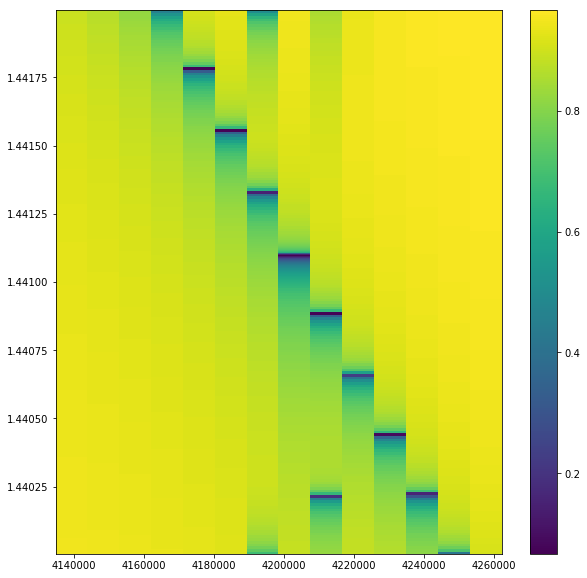

In [17]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.pcolormesh(ks[:,:,1], freqs[:,:]*hbar/eV, allS[:,:,-1])
plt.colorbar()
plt.savefig("figs/lMax%d%s%s%s_disp.pdf"%(lMax,tmtype,restype,note))

In [18]:
lineindex = nk//2
linek = ks[0,lineindex]
linefreqs = freqs[:,lineindex]
lineWmatrices = Wmatrices[:,lineindex]


In [19]:
# Full problem
TE_or_TM = None # just that the scripts below know...
lineU = np.full((nomega,npart*2*nelem,npart*2*nelem), np.nan, dtype=complex)
lineV = np.full((nomega,npart*2*nelem,npart*2*nelem), np.nan, dtype=complex)
lineS = np.full((nomega,npart*2*nelem), np.nan)
for omi in range(nomega):
        W = lineWmatrices[omi]
        T = TMatrices_interp(linefreqs[omi]) 
        TW = np.sum(
            T[...,ň,:,:,:,:,ň,ň,ň] * W[...,:,ň,ň,:,:,:,:,:]
        , axis = (-5,-4))
        iden = np.eye(npart*2*nelem)
        iden.shape = (npart,2,nelem,npart,2,nelem)
        finalMatrix = iden-TW
        try:
            lineU[omi], lineS[omi], lineV[omi] = scipy.linalg.svd(finalMatrix.reshape((npart*2*nelem,npart*2*nelem)), 
                                                                        lapack_driver= 'gesvd')
        except ValueError:
            pass
lineV_expanded = lineV.reshape(nomega, npart*2*nelem, 2, 2, nelem)
restype="Full"  

In [59]:
# Z-symmetric problem
TE_or_TM = 1 # 0 is TE

TE_yz = np.arange(nelem)
TM_yz = TE_yz
my, ny = qpms.get_mn_y(lMax)
TE_NMz = (my + ny) % 2
TM_NMz = (1 - TE_NMz)
T_NMz = TE_NMz if TE_or_TM == 0 else TM_NMz
T_yz = TE_yz if TE_or_TM == 0 else TM_yz
y = np.arange(nelem)
yi = y[ň,ň,ň,:]
yj = y[ň,:,ň,ň]
ipart = np.arange(npart)
ti = np.arange(2)

lineU = np.full((nomega,npart*nelem,npart*nelem), np.nan, dtype=complex)
lineV = np.full((nomega,npart*nelem,npart*nelem), np.nan, dtype=complex)
lineS = np.full((nomega,npart*nelem), np.nan)
for omi in range(nomega):
        W = lineWmatrices[omi][..., ipart[:,ň,ň,ň], T_NMz[ň,:,ň,ň],T_yz[ň,:,ň,ň], ipart[ň,ň,:,ň], T_NMz[ň,ň,ň,:],T_yz[ň,ň,ň,:]] # [Npart,2,nelem,Npart,2,nelem] -> [Npart,nelem,Npart,nelem]
        W[np.isclose(W,0, atol = 1e-10)] = 0
        T = TMatrices_interp(linefreqs[omi])[...,T_NMz[:,ň],T_yz[:,ň],T_NMz[ň,:],T_yz[ň,:]]  #[2,nelem,2,nelem] -> [nelem,nelem]
        TW = np.sum(
            T[...,ň,:,:,ň,ň] * W[...,:,ň,:,:,:]
        , axis = (-3))
        iden = np.eye(npart*nelem)
        iden.shape = (npart,nelem,npart,nelem)
        finalMatrix = iden-TW
        try:
            lineU[omi], lineS[omi], lineV[omi] = scipy.linalg.svd(finalMatrix.reshape((npart*nelem,npart*nelem)), 
                                                                       # lapack_driver= 'gesvd'
                                                                       )
        except ValueError:
            pass

#theV = allV[:,:,sorder,:].reshape(nomega,nk,2,2,nelem)
lineV_expanded = np.zeros((nomega,npart*nelem,2,2,nelem),dtype=complex)
for t in (0,1):
    lineV_expanded[:,:,:,t,T_NMz == t]  = lineV.reshape((nomega,npart*nelem,npart,nelem))[:,:,:,T_NMz == t]

if TE_or_TM == 0:
    restype="E-inplane"
elif TE_or_TM == 1:
    restype="M-inplane"
else:
    restype="WTF"

In [60]:
# "Final" SVD problem matrices to test projections onto irrep subspace
finalMatrices = np.empty((nomega, npart,2,nelem, npart,2,nelem), dtype=complex)
# Full problem
for omi in range(nomega):
        W = lineWmatrices[omi]
        T = TMatrices_interp(linefreqs[omi])
        TW = np.sum(
            T[...,ň,:,:,:,:,ň,ň,ň] * W[...,:,ň,ň,:,:,:,:,:]
        , axis = (-5,-4))
        iden = np.eye(npart*2*nelem)
        iden.shape = (npart,2,nelem,npart,2,nelem)
        finalMatrix = iden-TW
        finalMatrices[omi] = finalMatrix

In [61]:
### Zde se vybírá ""číslo"" modu
psi = 1
reps =  gen_hexlattice_Kpoint_svwf_rep(lMax, psi, vflip='y')
projmats, bases = gen_hexlattice_Kpoint_svwf_rep_projectors(lMax,psi, vflip='y',do_bases=True)

In [62]:
bases["E''"].shape

(20, 2, 2, 15)

In [63]:
projmats["E''"].shape

(2, 2, 15, 2, 2, 15)

In [64]:
reps["E''"].shape

(2, 2, 2, 2, 15, 2, 2, 15)

In [65]:
# test whether the symmetry group is correct (now mainly whether the psi sign is correct)
finalMatrices_projs = dict()
for rep, P in projmats.items():
    MP = np.tensordot(finalMatrices, P, axes=([-3,-2,-1],[0,1,2]))
    PMP = np.tensordot(P,MP, axes=([-3,-2,-1],[1,2,3]))
    PMP = np.rollaxis(PMP, 3)
    finalMatrices_projs[rep] = PMP

finalMatrices_reconstructed = np.zeros(finalMatrices.shape, dtype=complex)
for PMP in finalMatrices_projs.values():
    finalMatrices_reconstructed += PMP

In [66]:

np.amax(np.abs(finalMatrices-finalMatrices_reconstructed))
#finalMatrices[0]
#finalMatrices_reconstructed[0]
#finalMatrices[0]-finalMatrices_reconstructed[0]

1.0387457838910406e-09

In [67]:
TMatrices_projs = dict()
fullTMatrices = np.zeros((nomega, npart,2,nelem,npart,2,nelem), dtype=complex)
for omi in range(nomega):
    fullTMatrices[omi,0,:,:,0,:,:] = TMatrices_interp(linefreqs[omi])
    fullTMatrices[omi,1,:,:,1,:,:] = TMatrices_interp(linefreqs[omi])
for rep, P in projmats.items():
    TP = np.tensordot(fullTMatrices, P, axes=([-3,-2,-1],[0,1,2]))
    PTP = np.tensordot(P,TP, axes=([-3,-2,-1],[1,2,3]))
    PTP = np.rollaxis(PTP, 3)
    TMatrices_projs[rep] = PTP

TMatrices_reconstructed = np.zeros(fullTMatrices.shape, dtype=complex)
for PTP in TMatrices_projs.values():
    TMatrices_reconstructed += PTP

In [68]:
np.amax(np.abs(TMatrices_reconstructed-fullTMatrices))

8.673617379884035e-19

In [69]:
WMatrices_projs = dict()
for rep, P in projmats.items():
    WP = np.tensordot(lineWmatrices, P, axes=([-3,-2,-1],[0,1,2]))
    PWP = np.tensordot(P,WP, axes=([-3,-2,-1],[1,2,3]))
    PWP = np.rollaxis(PWP, 3)
    WMatrices_projs[rep] = PWP

WMatrices_reconstructed = np.zeros(lineWmatrices.shape, dtype=complex)
for PWP in WMatrices_projs.values():
    WMatrices_reconstructed += PWP

In [70]:
(np.amax(np.nan_to_num(np.abs(WMatrices_reconstructed-lineWmatrices)/(np.abs(WMatrices_reconstructed)+np.abs(lineWmatrices)))),
 np.amax(np.abs(WMatrices_reconstructed-lineWmatrices)))

/u/46/necadam1/unix/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


(1.0, 7.963936141273393e-08)

In [71]:
lineS_irrep = dict()
for rep, B in bases.items():
    N = B.shape[0]
    lineS_thisirrep = np.full((nomega,N), np.nan)
    #B_H = np.moveaxis(B,0, -1).conj() # (N,2,2,nelem) -> (2,2,nelem,N)
    B_H = B.conj()
    B = np.moveaxis(B,0,-1)
    for omi in range(nomega):
            M = finalMatrices[omi]
            MB = np.tensordot(M,B,axes=([-3,-2,-1],[0,1,2]))
            finalMatrix_irrep = np.tensordot(B_H, MB, axes=([-3,-2,-1],[0,1,2]))
            try:
                #allU[omi,ki], allS[omi,ki], allV[omi,ki] = scipy.linalg.svd(finalMatrix.reshape((npart*nelem,npart*nelem)), 
                lineS_thisirrep[omi] = scipy.linalg.svd(finalMatrix_irrep, compute_uv = False,
                                                                           # lapack_driver= 'gesvd'
                                                                           )
            except ValueError:
                pass
    lineS_irrep[rep] = lineS_thisirrep

    
    

E' 1.4410990535953898
A1' 1.441109314598288
A2' 1.4411089199443305
E'' 1.4410962910176868
A1'' 1.4411089199443305
A2'' 1.4410584042377554


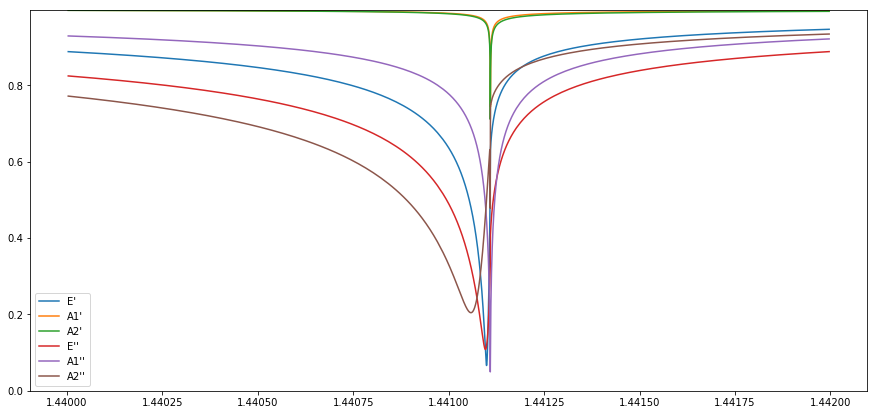

In [72]:
s = 1
plt.figure(figsize=(15,7))
amaxes = []
for rep in ["E'", "A1'", "A2'", "E''", "A1''", "A2''"]:
    lineSp = lineS_irrep[rep]
    plt.plot(linefreqs/eV*hbar, lineSp[:,-s], label=rep)
    amaxes.append(np.amax(lineSp[:,-s]))
plt.ylim([0,min(2, max(amaxes))])

plt.legend()
plt.savefig("figs/lMax%d%sPsi%d%s_irrep_SVs%d.pdf"%(lMax,tmtype,psi,note,s))
"figs/lMax%d%sPsi%d%s_irrep_SVs%d.pdf"%(lMax,tmtype,psi,note,s)
for rep in ["E'", "A1'", "A2'", "E''", "A1''", "A2''"]:
    print(rep, linefreqs[np.argmin(lineS_irrep[rep][:,-s])]/eV*hbar)

In [73]:

for sorder in (-1,):#,-2,-3,-4,-5):
    # Change this for full / zsym solutions
    #theV = allV[:,:,sorder,:].reshape(nomega,nk,2,2,nelem)
    theV = lineV_expanded[:,sorder,:,:,:]

    theVprojections_v1 = dict() # non-normalised projector (probably this one is correct)
    theVprojections_v2 = dict() # normalised projector
    theVprojections_v3 = dict() # normalised projector squared

    for repkey, rep in reps.items():
        genvec = np.ones((2,2,nelem))
        symproj = np.tensordot(rep, genvec, axes = ([-3,-2,-1],[0,1,2])) #[d,d,p,t,y]; old method
        projmat = projmats[repkey]
        #FIXME tenhle přísstup je možná taky blbě, já vlastně chci spíš možná sčítat čtverce z theV...
        theVprojections_pre = np.abs(np.sum(theV[:,ň,ň,:,:,:] * symproj, axis=(-3,-2,-1))) #[nomega,nk,d,d] # raději kvadrát???
        theVprojections_v1[repkey] = np.sum(theVprojections_pre, axis = (-2,-1))
        theVprojections_v2[repkey] = np.sum(theVprojections_pre / np.sum(symproj*symproj.conj(),axis=(-3,-2,-1)).real,(-2,-1))
        theV_halfproj = np.tensordot(theV.conjugate(),projmat, axes=([-3,-2,-1],[0,1,2])) 
        theVprojections_v3[repkey] = np.sum( theV_halfproj[:,:,:,:] * theV[:,:], axis = (-3,-2,-1)  ).real
        
        
                                                  

    if TE_or_TM is None:
        repkeylist = ["A1'", "A1''", "A2'", "A2''", "E'", "E''"]# list(reps.keys())
    elif TE_or_TM ==0:
        repkeylist = ["A1'", "A2'", "E'",]# list(reps.keys())
    elif TE_or_TM ==1:
        repkeylist = ["A1''", "A2''", "E''"]# list(reps.keys())
    else:
        raise ValueError('TE_or_TM has wrong value (or has not been set?)')


    theVprojections_v1_arr = np.empty((nomega,len(repkeylist)), dtype=float)
    theVprojections_v2_arr = np.empty((nomega,len(repkeylist)), dtype=float)
    theVprojections_v3_arr = np.empty((nomega,len(repkeylist)), dtype=float)
    for i in range(len(repkeylist)):
        theVprojections_v1_arr[:,i] = theVprojections_v1[repkeylist[i]]
        theVprojections_v2_arr[:,i] = theVprojections_v2[repkeylist[i]]
        theVprojections_v3_arr[:,i] = theVprojections_v3[repkeylist[i]]

    #for key in repkeylist:
    #    plt.figure(figsize=(10,10))
    #    plt.pcolormesh(ks[:,:,1], freqs[:,:]*hbar/eV, theVprojections_v3[key], )
    #    plt.title(key)
    #    plt.colorbar()

In [74]:
theVprojections_v1_order = np.argsort(theVprojections_v1_arr, axis = -1)
theVprojections_v2_order = np.argsort(theVprojections_v2_arr, axis = -1)
theVprojections_v3_order = np.argsort(theVprojections_v3_arr, axis = -1)

In [75]:
lineV_expanded.shape

(683, 30, 2, 2, 15)

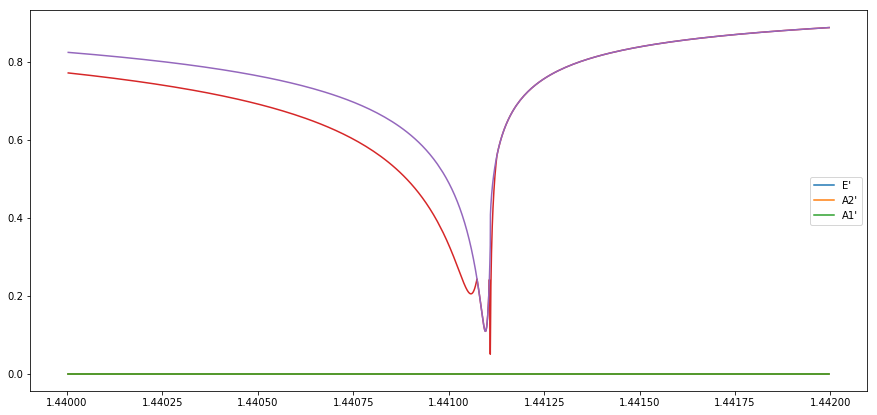

In [76]:

plt.figure(figsize=(15,7))
xen = freqs[:,0]*hbar/eV
plt.plot(xen,theVprojections_v3["E'"][:],label = "E'")
plt.plot(xen,theVprojections_v3["A2'"][:],label = "A2'")
plt.plot(xen,theVprojections_v3["A1'"][:], label= "A1'")
plt.plot(xen,lineS[:,-1])
plt.plot(xen,lineS[:,-2])
plt.legend()
plt.savefig("figs/lMax%d%s%spsi%d%s_Elines.pdf"%(lMax,tmtype,restype,psi,note))

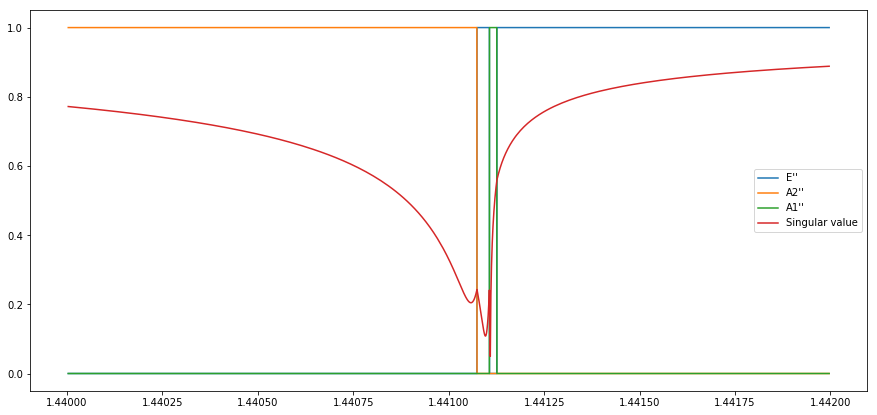

In [77]:

plt.figure(figsize=(15,7))
plt.plot(xen,theVprojections_v3["E''"][:],label = "E''")
plt.plot(xen,theVprojections_v3["A2''"][:],label = "A2''")
plt.plot(xen,theVprojections_v3["A1''"][:], label= "A1''")
plt.plot(xen,lineS[:,-1], label='Singular value')
#plt.plot(xen,lineS[:,-2], label='Singular value 2')

plt.legend()
plt.savefig("figs/lMax%d%s%spsi%d%s_Mlines.pdf"%(lMax,tmtype,restype,psi,note))

In [78]:
i=145
wdata['freqs_weirdunits'][i], wdata['freqs'][i]/eV*hbar

(7.145, 1.4409984168361973)